# Final ML Modeling

Now we create ML model for our final data(preprocessed and  featurized).

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine 
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [3]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
data = pd.read_csv('/content/drive/My Drive/ML_Projects/final_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Columns: 221 entries, Unnamed: 0 to 95_y
dtypes: float64(209), int64(10), object(2)
memory usage: 681.7+ MB


In [ ]:
data.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_words,q2_words,words_total,words_common,words_shared,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,mean_len,abs_len_diff,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,1,2,step step guide invest share market india,step step guide invest share market,0,41.0,35.0,6.0,5.0,11.0,5.0,0.454541,0.999980,0.833319,0.999983,0.999983,0.999980,0.833319,0.0,1.0,92,100,92,100,38.0,6,0.999997,-6.774074,34.750269,-63.338417,31.332882,131.444493,126.208747,12.765218,49.562372,77.243199,213.083153,23.191339,...,112.765260,24.830739,-46.705255,106.934580,92.727107,-68.758488,77.785301,38.983751,-16.574593,-96.957138,63.479529,-40.722856,-57.340737,43.841183,-106.014298,10.464895,-0.576249,-27.064501,-73.275132,73.519828,122.627077,-115.435044,17.679101,19.151915,35.213065,-78.687422,-58.025264,2.711149,-55.300582,-45.336227,-66.086482,-36.057322,-30.581925,85.013424,-39.347170,-28.962603,-69.927603,91.722557,47.135722,-15.909275
1,1,1,3,4,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,0,31.0,67.0,5.0,10.0,15.0,4.0,0.266665,0.799984,0.399996,0.749981,0.599988,0.799984,0.399996,0.0,0.0,59,94,59,89,49.0,36,0.838707,9.433686,-79.131060,-43.922241,77.005098,174.043648,97.115964,68.655497,46.820807,123.824580,106.663648,70.832820,...,179.445625,110.034502,-74.123426,-61.008009,-68.326804,-105.094937,16.276140,11.939991,42.675999,31.363578,46.985973,-24.929567,-51.992155,91.288072,-69.158965,82.455325,2.501214,-11.595707,-46.993275,19.165810,168.643459,-73.277191,-47.348445,-2.813164,11.964179,-195.263801,-45.547664,83.273906,1.820177,3.403991,4.960035,-64.955359,-16.711752,-6.593193,26.653954,163.125637,-52.334212,182.633432,124.281454,51.769534
2,2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0,44.0,36.0,6.0,5.0,11.0,2.0,0.181817,0.399992,0.333328,0.399992,0.249997,0.399992,0.333328,0.0,0.0,55,46,65,65,40.0,8,0.249999,89.384422,21.821515,-39.258011,19.559112,51.069989,49.337402,6.360558,33.185292,100.235138,209.872408,-2.721161,...,11.564563,-56.951482,37.601083,33.701925,103.168292,-69.006286,-12.643299,36.328767,-43.651735,-134.645773,11.708356,-51.453714,-57.327870,96.407419,1.571282,-21.919096,34.961125,-22.948426,21.550711,10.371201,142.856879,-68.909339,-18.241170,-25.780885,11.513604,-21.569222,-43.559399,39.124646,47.041573,-54.624664,-25.935167,-19.892332,67.710828,21.257845,-85.063138,-166.074766,-83.375707,19.157588,21.275942,47.427300
3,3,3,7,8,mentally lonely solve,find remainder math 23 24 math divided 24 23,0,21.0,44.0,3.0,6.0,9.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,22,24,18,22,32.5,23,0.047619,53.734828,-20.758162,-3.311567,-82.976245,-5.203976,-52.264970,68.284720,97.578963,12.762800,34.984449,-94.069841,...,41.883032,7.032984,14.439108,30.251516,38.480972,-96.800548,29.598695,-30.857314,-63.458220,-21.074069,17.152544,19.138870,-3.911113,43.551102,13.444363,79.730679,55.740659,-32.710705,27.434486,-0.396669,44.486013,-50.601605,-24.893668,-5.069469,-45.543428,-32.385300,23.405810,78.486409,-26.104745,-60.641748,-17.756890,27.090456,45.906384,24.514372,24.378251,-28.192598,-3.304734,-10.862875,6.252828,6.728697
4,4,4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,60.0,29.0,10.0,5.0,15.0,2.0,0.133332,0.399992,0.199998,0.999950,0.666644,0.399992,0.199998,0.0,0.0,25,52,40,51,44.5,31,0.206896,78.476715,-37.941603,-81.340270,-48.872866,73.861554,-16.839037,50.360948,92.193217,153.706277,274.637285,46.212472,...,67.871890,18.176489,-49.458324,133.935620,76.070458,-62.891350,52.941874,34.069120,50.8

In [5]:
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','qid1', 'qid2', 'question1', 'question2' ,'is_duplicate'], axis = 1, inplace = True)

In [ ]:
data.head()

,qid1,qid2,question1,question2,q1_len,q2_len,q1_words,q2_words,words_total,words_common,words_shared,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,mean_len,abs_len_diff,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,1,2,step step guide invest share market india,step step guide invest share market,41.0,35.0,6.0,5.0,11.0,5.0,0.454541,0.999980,0.833319,0.999983,0.999983,0.999980,0.833319,0.0,1.0,92,100,92,100,38.0,6,0.999997,-6.774074,34.750269,-63.338417,31.332882,131.444493,126.208747,12.765218,49.562372,77.243199,213.083153,23.191339,-5.301361,42.708241,-98.252434,...,112.765260,24.830739,-46.705255,106.934580,92.727107,-68.758488,77.785301,38.983751,-16.574593,-96.957138,63.479529,-40.722856,-57.340737,43.841183,-106.014298,10.464895,-0.576249,-27.064501,-73.275132,73.519828,122.627077,-115.435044,17.679101,19.151915,35.213065,-78.687422,-58.025264,2.711149,-55.300582,-45.336227,-66.086482,-36.057322,-30.581925,85.013424,-39.347170,-28.962603,-69.927603,91.722557,47.135722,-15.909275
1,3,4,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,31.0,67.0,5.0,10.0,15.0,4.0,0.266665,0.799984,0.399996,0.749981,0.599988,0.799984,0.399996,0.0,0.0,59,94,59,89,49.0,36,0.838707,9.433686,-79.131060,-43.922241,77.005098,174.043648,97.115964,68.655497,46.820807,123.824580,106.663648,70.832820,-46.118228,32.779621,-76.706208,...,179.445625,110.034502,-74.123426,-61.008009,-68.326804,-105.094937,16.276140,11.939991,42.675999,31.363578,46.985973,-24.929567,-51.992155,91.288072,-69.158965,82.455325,2.501214,-11.595707,-46.993275,19.165810,168.643459,-73.277191,-47.348445,-2.813164,11.964179,-195.263801,-45.547664,83.273906,1.820177,3.403991,4.960035,-64.955359,-16.711752,-6.593193,26.653954,163.125637,-52.334212,182.633432,124.281454,51.769534
2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,44.0,36.0,6.0,5.0,11.0,2.0,0.181817,0.399992,0.333328,0.399992,0.249997,0.399992,0.333328,0.0,0.0,55,46,65,65,40.0,8,0.249999,89.384422,21.821515,-39.258011,19.559112,51.069989,49.337402,6.360558,33.185292,100.235138,209.872408,-2.721161,-64.818267,-47.233395,-106.903570,...,11.564563,-56.951482,37.601083,33.701925,103.168292,-69.006286,-12.643299,36.328767,-43.651735,-134.645773,11.708356,-51.453714,-57.327870,96.407419,1.571282,-21.919096,34.961125,-22.948426,21.550711,10.371201,142.856879,-68.909339,-18.241170,-25.780885,11.513604,-21.569222,-43.559399,39.124646,47.041573,-54.624664,-25.935167,-19.892332,67.710828,21.257845,-85.063138,-166.074766,-83.375707,19.157588,21.275942,47.427300
3,7,8,mentally lonely solve,find remainder math 23 24 math divided 24 23,21.0,44.0,3.0,6.0,9.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,22,24,18,22,32.5,23,0.047619,53.734828,-20.758162,-3.311567,-82.976245,-5.203976,-52.264970,68.284720,97.578963,12.762800,34.984449,-94.069841,-13.067765,139.368599,94.484831,...,41.883032,7.032984,14.439108,30.251516,38.480972,-96.800548,29.598695,-30.857314,-63.458220,-21.074069,17.152544,19.138870,-3.911113,43.551102,13.444363,79.730679,55.740659,-32.710705,27.434486,-0.396669,44.486013,-50.601605,-24.893668,-5.069469,-45.543428,-32.385300,23.405810,78.486409,-26.104745,-60.641748,-17.756890,27.090456,45.906384,24.514372,24.378251,-28.192598,-3.304734,-10.862875,6.252828,6.728697
4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,60.0,29.0,10.0,5.0,15.0,2.0,0.133332,0.399992,0.199998,0.999950,0.666644,0.399992,0.199998,0.0,0.0,25,52,40,51,44.5,31,0.206896,78.476715,-37.941603,-81.340270,-48.872866,73.861554,-16.839037,50.360948,92.193217,153.706277,274.637285,46.212472,23.2

## Train - Test Split(70 : 30)

pandas.core.series.Series

In [6]:
x_train, x_test, y_train, y_test = train_test_split(data, y_true, test_size = 0.3)

In [ ]:
print("Number of data points in train : ", x_train.shape[0])
print("Number of data point in test : ", x_test.shape[0])

Number of data points in train :  283003
Number of data point in test :  121287


In [7]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    
    B =(C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# 2.1 Building Random Model for worst case scnerio

Log loss on Test Data using Random Model 0.8843309033276239


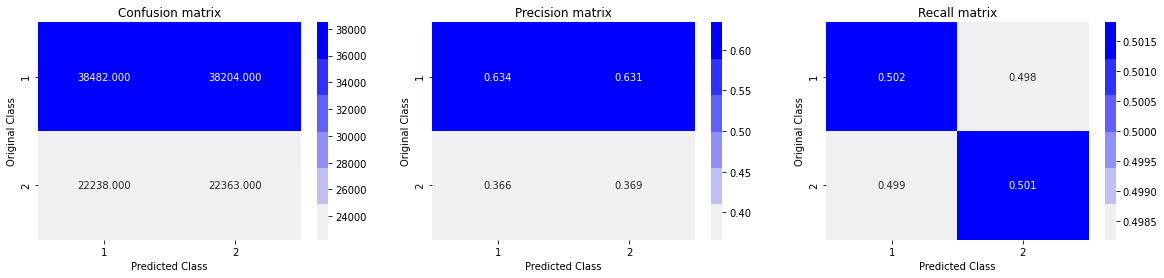

In [ ]:
#exactly same size as the CV data
test_len = len(y_test)
train_len = len(y_train)
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# 2.2 Logistic Regression with Hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.5576142951160223
For values of alpha =  0.0001 The log loss is: 0.5530489946987308
For values of alpha =  0.001 The log loss is: 0.548445229824679
For values of alpha =  0.01 The log loss is: 0.5257417560363247
For values of alpha =  0.1 The log loss is: 0.529612794691027
For values of alpha =  1 The log loss is: 0.5457715401514471
For values of alpha =  10 The log loss is: 0.5565646255826227


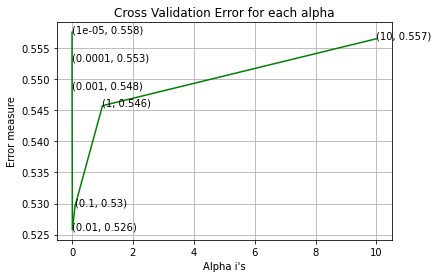

For values of best alpha =  0.01 The train log loss is: 0.5228870308221469
For values of best alpha =  0.01 The test log loss is: 0.5257417560363247
Total number of data points : 121287


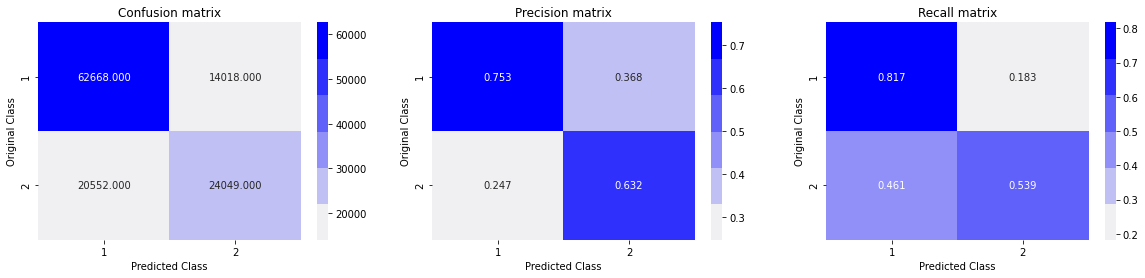

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# 2.3 Linear SVM with hyperparamter tuning

For values of alpha =  1e-05 The log loss is: 0.5465807687373918
For values of alpha =  0.0001 The log loss is: 0.5558197431968697
For values of alpha =  0.001 The log loss is: 0.5491315497596453
For values of alpha =  0.01 The log loss is: 0.533789863057763
For values of alpha =  0.1 The log loss is: 0.6093873763222306
For values of alpha =  1 The log loss is: 0.6364525880912241
For values of alpha =  10 The log loss is: 0.6580351094741663


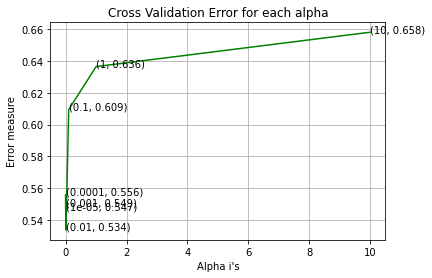

For values of best alpha =  0.01 The train log loss is: 0.5338106610798011
For values of best alpha =  0.01 The test log loss is: 0.533789863057763
Total number of data points : 121287


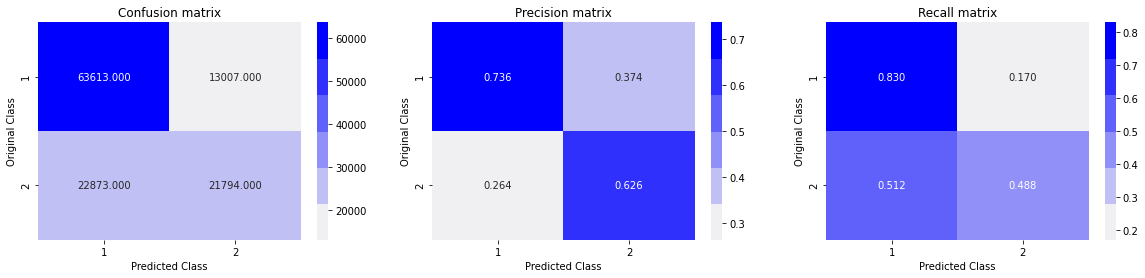

In [8]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test) 
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Conclusion

So we have our Results now for both the model.
1. Logistic Regression with Hyperparameter tuning : 
    best aplha  = 0.01 with log-loss = 0.52 (approx)
2. Linear SVM with Hyperparameter tuning : 
    best alpha = 0.01 with log-loss = 0.53

Hence, both the models performs similar. But logistic Regression is fast for larger datasets hence, we can consider logistic regression as a best fit among these two models.

